In [8]:
# https://www.youtube.com/watch?v=xkuoZ50gK4Q

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from PIL import Image
# from extract_bb import show_img_bb, extract_bb

import requests
from torchvision.models import resnet50


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
# image_path = "../04Training_Data2/train/images/T1D0pa0dataset0.jpg"
# label_path = "../04Training_Data2/train/labels/T1D0pa0dataset0.txt"

# img = cv2.imread(image_path)

# # Resize to 800 by 800 for vgg
# img = cv2.resize(img, dsize=(800,800), interpolation=cv2.INTER_CUBIC)
# x_min, y_min, x_max, y_max = extract_bb(label_path, image_path, 800)
# bbox0 = [[int(x_min), int(y_min), int(x_max), int(y_max)]]
# bbox = np.array(bbox0)
# print(bbox)

# show_img_bb(label_path, image_path, size = 800)

#### DETR

In [20]:
class DETR(nn.Module):
    def __init__(self, num_classes, hidden_dim = 256, nheads = 8, num_encoder_layers = 6, num_decoder_layers = 6):
        super().__init__()
        
        # Create ResNet 50 Backbone and delete fully connected layer at the end
        self.backbone = resnet50()
        del self.backbone.fc
        
        # create conversion layers, 2048 from resnet50
        self.conv = nn.Conv2d(2048, hidden_dim, 1)
        
        # create a default PyTorch transformer
        self.transformer = nn.Transformer(hidden_dim, nheads, num_encoder_layers, num_decoder_layers)
        
        # Prediction heads, take embeddings of decoder and map distribution to classes
        # or gives us bounding boxes for each of the tokens
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)
        
        # Output positinal encodings (object quereies), currently built with 100
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))
        
        # Positional Encoding
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim//2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim//2))
        
    def forward(self, inputs):
        
        # Propagate through ResNet50
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        # convert from 2048 to 256 for transformer
        h = self.conv(x)
        
        # construct positional encodings 
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1,W, 1),
        ], dim = -1).flatten(0,1).unsqueeze(1)
        
        # Propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2,0,1),
                             self.query_pos.unsqueeze(1)).transpose(0,1)
        
        # Project transformer outputs to class labels and bounding boxes
        return {"pred_logits": self.linear_class(h),
                "pred_boxes": self.linear_bbox(h).sigmoid()}
    

In [21]:
# Load a pretrained detr model
detr = DETR(num_classes = 91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu',
    check_hash = True)

detr.load_state_dict(state_dict)
detr.eval()

DETR(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [22]:
with open('coco-labels-91.txt', 'r') as file:
    CLASSES = [line.strip() for line in file.readlines()]
    
print(CLASSES[0:10])
print(len(CLASSES))

COLORS = [[0.000, 0.477, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.647, 0.188], [0.301, 0.745, 0.933]]


['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'trafficlight']
91


In [79]:
transform = T.Compose([
    
    T.ToTensor(),
    
    # Calculated over ImageNet Dataset
    # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# DETR puts boxes in relative image coordinates with x center, y center, width and height format. THus, we need to convert it back to image coordinates
# Coordinates lie between [0,1], we convert the predictions to absolute image coordinates 
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5*w), (y_c - 0.5*h),
         (x_c + 0.5*w), (y_c + 0.5*h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype= torch.float32)
    return b

In [80]:
def detect(img, model, transform):
    # Add dummy dimension 1 for batch
    img = transform(img)
    img_size = img.size()[-2:]
    img = img.unsqueeze(0)

    
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, "demo model only supports up to 1600 * 1600"
    
    outputs = model(img)
    
    # Keep only predictions with 0.7+ confidence
    # Apply softmax except for the noclasses (which is -1)
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    # We find max on each dimension and return also only the values that are greater than 0.7
    keep = probas.max(-1).values > 0.7
    
    # convert boxes to image scale
    bbox_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], img_size)
    return probas[keep], bbox_scaled
    

In [81]:
url = "/Users/christianaltrichter/Desktop/AI_Master/Master_Thesis/04Training_Data2/train/images/T1D0pa0dataset0.jpg"
# url = "../04Training_Data2/train/images/T1D0pa0dataset0.jpg"
img = Image.open(url)
print(img.size)

score, boxes = detect(img, detr, transform)

print(score.shape, boxes.shape)

(1024, 1024)
torch.Size([4, 91]) torch.Size([4, 4])


(1024, 1024)


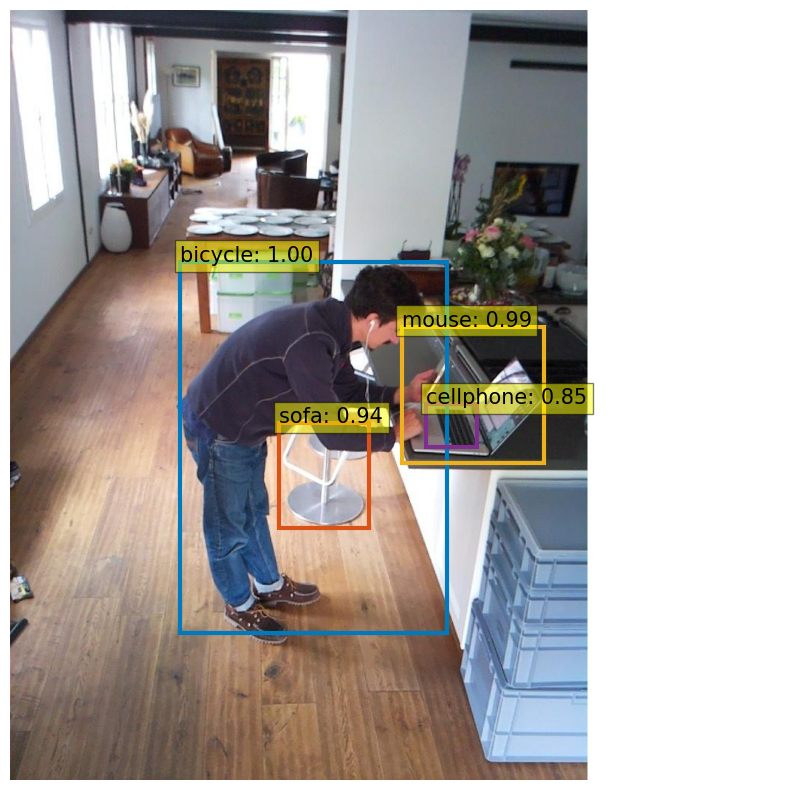

In [82]:
def plot_results(pil_img, prob, boxes):
    print(pil_img.size)
    plt.figure(figsize = (16,10))
    plt.imshow(pil_img)
    
    ax = plt.gca()
    
    for p, (x_min, y_min, x_max, y_max), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max- y_min, 
                                  fill=False, color = c, linewidth=3))
        
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(x_min, y_min, text, fontsize = 15, 
                bbox = dict(facecolor='yellow', alpha = 0.5))
        
    plt.axis('off')
    plt.show()
       
 
plot_results(img, score, boxes)
    
    